## Generic Test

In [ ]:
from LambdaSARSA import LambdaSARSA
import gymnasium as gym

env = gym.make('LunarLander-v2')
lam_sarsa = LambdaSARSA(env)
lam_sarsa.train(num_replications=5, num_episodes=200)
lam_sarsa.get_results()
lam_sarsa.show_results()
lam_sarsa.display_best_policy()

## WANDB Sweep

In [ ]:
!rm -r __pycache__/
import wandb
from LSPI import LSPI

sweep_config = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "Score"},
    'parameters': {
        'alpha_a': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'alpha_b': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'eps_a': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'eps_b': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'eta': {'distribution': 'log_uniform', 'min': 1e-7, 'max': 1e-5},
        'n_batch_size': {'distribution': 'log_uniform', 'min': 2**8, 'max': 2**10},
    }
}

#wandb.init(project="DSOR 646 - Final")
sweep_id = wandb.sweep(sweep=sweep_config, project="my-first-sweep")

import gymnasium as gym
env = gym.make('MountainCar-v0')

def main():
    run = wandb.init()
    model = LSPI(env,
        alpha_a = wandb.config.alpha_a,
        alpha_b = wandb.config.alpha_b,
        eps_a = wandb.config.eps_a,
        eps_b = wandb.config.eps_b,
        eta = wandb.config.eta,
        n_batch_size = wandb.config.n_batch_size
        )
    model.train(num_replications=10,num_episodes=300)
    maxETDR, maxETDRhw, meanMaxTestEETDR, maxTestHW, meanAULC, hwAULC, time = model.get_results()
    alg_score = 0.6*(meanMaxTestEETDR-maxTestHW) + 0.4*(meanAULC-hwAULC)
    wandb.log({
            "maxETDR": maxETDR,
            "maxETDRhw": maxETDRhw,
            "meanMaxTestEETDR": meanMaxTestEETDR,
            "maxTestHW": maxTestHW,
            "meanAULC": meanAULC,
            "hwAULC": hwAULC,
            "time": time,
            "Score": alg_score
        })

# Start sweep job.
wandb.agent(sweep_id, function=main, count=5)

## Additions Test

In [ ]:
from MDP import MDP_Tiled, FourierBasis
from SemiGradSARSA import SemiGradSARSA

import numpy as np
from time import perf_counter
from tiles3 import tiles

!rm -r __pycache__/

class SemiGradSARSA_fourier(SemiGradSARSA):
    name = "Semi-gradient n-step SARSA"

    def __init__(self, env, n=1, basis_order=2, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name = f"Semi-gradient {n}-step SARSA with {basis_order} order Fourier Basis"
        self.nm1 = n-1
        self.fourier_basis = FourierBasis(self.Ssize, basis_order)

        self.max_size = len(self.fourier_basis.coefficients)
        self.scale_factor = self.fourier_basis.transform(self.scale_factor)

    #@override(MDPBase) # Needs Python >3.12
    def phi(self,s,a,iht):
        s = self.fourier_basis.transform(s)
        return tiles(iht, self.num_tiles,list(s*self.scale_factor),[a])


import gymnasium as gym
env = gym.make('LunarLander-v2')
sgsf = SemiGradSARSA_fourier(env)
sgsf.train(num_replications=5, num_episodes=100)
#sgsf.get_results()
##sgsf.show_results()
#sgsf.display_best_policy()

In [ ]:
sgsf.show_results()

rm: __pycache__/: No such file or directory

Semi-grad 8-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 0...
IHT full, starting to allow collisions

Semi-grad 8-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 1...
IHT full, starting to allow collisions

Semi-grad 8-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 2...
IHT full, starting to allow collisions

Semi-grad 8-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 3...
IHT full, starting to allow collisions

Semi-grad 8-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 4...
IHT full, starting to allow collisions
Executed 5 algorithm reps in 21.3754 seconds.

Best VFA (1st) test... EETDR CI: -165.5 +/- 40.5

Best VFA (2nd) test... EETDR CI: -176.6 +/- 40.5

Best VFA (3rd) test... EETDR CI: -179.9 +/- 39.0

Best VFA (4th) test... EETDR CI: -202.2 +/- 50.6

Best VFA (5th) test... EETDR CI: -189.3 +/- 47.0

Best VFA (6th) test... EETDR CI: -201.8 +/- 42.1

Best

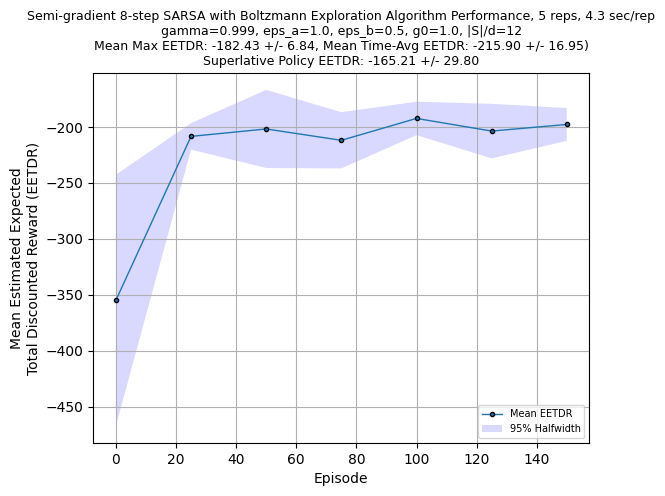

In [2]:
from SemiGradSARSA import SemiGradSARSA

import numpy as np
!rm -r __pycache__/

class SemiGradSARSA_boltzmann(SemiGradSARSA):
    name = "Semi-gradient n-step SARSA"

    def __init__(self, env, n=1, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name = f"Semi-gradient {n}-step SARSA with Boltzmann Exploration"
        self.nm1 = n-1
        self.tau            = kwargs.get('tau',1.0)
        self._tau_          = self.tau
        self.cooling_rate   = kwargs.get('cooling_rate',0.000001)


    #@override(SemiGradSARSA) # Needs Python >3.12
    def get_action(self, state, policy, epsilon=0) -> int:
        w, iht = policy
        Qvals = np.array([self.Qbar(state,a,w,iht) for a in range(self.num_actions)])
        exp_q = np.clip(np.exp(Qvals / self.tau), 1e-10, 1e10)
        self.tau = self.tau * (1-self.cooling_rate) # Apply Cooling
        probabilities = exp_q / np.sum(exp_q)
        action = np.random.choice(range(self.num_actions), p=probabilities)
        return action

    #@override(MDPBase) # Needs Python >3.12
    def end_episode_callbacks(self) -> None:
        self.tau = self._tau_


import gymnasium as gym
env = gym.make('LunarLander-v2')
sgsb = SemiGradSARSA_boltzmann(env, n=8)
sgsb.train(num_replications=5, num_episodes=150)
#sgsb.get_results()
sgsb.show_results()
#sgsb.display_best_policy()

rm: __pycache__/: No such file or directory

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep0...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep1...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep2...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep3...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep4...
IHT full, starting to allow collisions
Executed 5 algorithm reps in 30.5353 seconds.

Best VFA (1st) test... EETDR CI:  -95.4 +/- 33.3

Best VFA (2nd) test... EETDR CI: -118.8 +/- 38.4

Best VFA (3rd) test... EETDR CI: -106.0 +/- 43.0

Best VFA (4th) test... EETDR CI: -100.2 +/- 37.9

Best VFA (5th) test... EETDR CI:  -83.8 +/- 36.5

Best VFA (6th) test... EETDR CI: -145.9 +/- 42.4

Best VFA (7th) test... EETDR CI:  -88.6 +/- 23.4

Best VFA (8th)

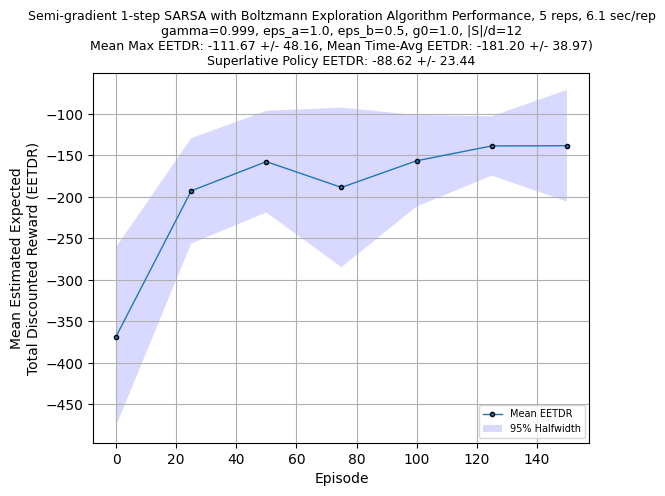

In [5]:
from LambdaSARSA import LambdaSARSA

import numpy as np
!rm -r __pycache__/

class LambdaSARSA_boltzmann(LambdaSARSA):
    name = "SARSA (lambda) with linear tile coding VFA scheme and Boltzmann Exploration"

    def __init__(self, env, n=1, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name = self.name
        self.tau            = kwargs.get('tau',2.0)
        self._tau_          = self.tau
        self.cooling_rate   = kwargs.get('cooling_rate',0.001)


    #@override(SemiGradSARSA) # Needs Python >3.12
    def get_action(self, state, policy, epsilon=0) -> int:
        w, iht = policy
        Qvals = np.array([self.Qbar(state,a,w,iht) for a in range(self.num_actions)])
        exp_q = np.clip(np.exp(Qvals / self.tau), 1e-10, 1e10)
        self.tau = self.tau * (1-self.cooling_rate) # Apply Cooling
        probabilities = exp_q / np.sum(exp_q)
        action = np.random.choice(range(self.num_actions), p=probabilities)
        return action

    #@override(MDPBase) # Needs Python >3.12
    def end_episode_callbacks(self) -> None:
        self.tau = self._tau_


import gymnasium as gym
env = gym.make('LunarLander-v2')
lsb = LambdaSARSA_boltzmann(env)
lsb.train(num_replications=5, num_episodes=150)
#lsb.get_results()
lsb.show_results()
#lsb.display_best_policy()